In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    
import os
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [86]:
def img_show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [77]:
class SiameseDataset(Dataset):
    def __init__(self, imageFolderDataset, transform):
        self.imageFolderDataset = imageFolderDataset   
        self.transform = transform
        
    def __getitem__(self, index):
        same_label = random.randint(0, 1)
        img0_path = random.choice(self.imageFolderDataset.imgs)
        
        if same_label:
            while True:
                img1_path = random.choice(self.imageFolderDataset.imgs)
                if img0_path[1] == img1_path[1]:
                    break
        else:
            while True:
                img1_path = random.choice(self.imageFolderDataset.imgs)
                if img0_path[1] != img1_path[1]:
                    break

        img0 = Image.open(img0_path[0])
        img1 = Image.open(img1_path[0])

        img0 = img0.convert('L')
        img1 = img1.convert('L')

        img0 = self.transform(img0)
        img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img0_path[1] != img1_path[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [78]:
folder_dataset = datasets.ImageFolder(r"../Downloads/faces/training/")
transformation = transforms.Compose([transforms.Resize((100,100)),
                                    transforms.ToTensor()])

siamese_dataset = SiameseDataset(imageFolderDataset=folder_dataset,
                                transform=transformation)

In [79]:
dataloader = DataLoader(dataset=siamese_dataset,
                       shuffle=True,
                       batch_size=8)

In [80]:
example = next(iter(dataloader))

In [83]:
conc = torch.cat((example[0], example[1]), 0)

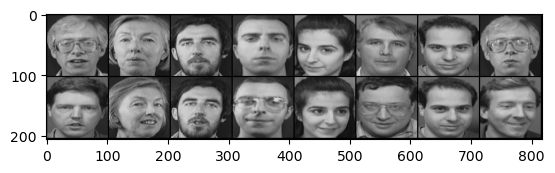

In [88]:
img_show(torchvision.utils.make_grid(conc))

In [81]:
example[2]

tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.]])

In [104]:
class SiameseNetwork(nn.Module):
    
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, stride=1),
            nn.ReLU(inplace=True)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 2)
        )
    
    def forward_once(self, x):
        x = self.cnn1(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        return x
    
    def forward(self, img1, img2):
        out1 = self.forward_once(img1)
        out2 = self.forward_once(img2)
        
        return out1, out2

In [113]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin = 2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin=margin
        
    def forward(self, out1, out2, label):
        l2 = F.pairwise_distance(out1, out2)
        loss = torch.mean((1-label)*torch.pow(l2, 2) + (label)*torch.pow(torch.clamp(self.margin-l2, min=0.0), 2))

        return loss

In [114]:
train_dataloader = DataLoader(dataset=siamese_dataset,
                       shuffle=True,
                       batch_size=64)

In [115]:
net = SiameseNetwork()
loss_function = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [119]:
counter = []
losses = []
iter_num = 0

for epoch in range(10):
    for i, (img0, img1, label) in enumerate(train_dataloader):
        optimizer.zero_grad()
        out1, out2 = net(img0, img1)
        contrastive_loss = loss_function(out1, out2, label)
        contrastive_loss.backward()
        optimizer.step()
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {contrastive_loss.item()}\n")
            counter.append(iter_num)
            losses.append(contrastive_loss.item())

Epoch number 0
 Current loss 1.4418931007385254

Epoch number 1
 Current loss 1.3102461099624634

Epoch number 2
 Current loss 1.4460885524749756

Epoch number 3
 Current loss 1.3250476121902466

Epoch number 4
 Current loss 1.257838249206543

Epoch number 5
 Current loss 1.3336671590805054

Epoch number 6
 Current loss 1.3530551195144653

Epoch number 7
 Current loss 1.3651448488235474

Epoch number 8
 Current loss 1.3109550476074219

Epoch number 9
 Current loss 1.2754154205322266



In [122]:
test_folder_dataset = datasets.ImageFolder(r"../Downloads/faces/testing/")
test_dataset = SiameseDataset(test_folder_dataset, transform=transformation)
test_loader = DataLoader(test_dataset, batch_size=1)

Dissimilarity: 1.05
Dissimilarity: 0.95
Dissimilarity: 1.05
Dissimilarity: 0.31
Dissimilarity: 0.54


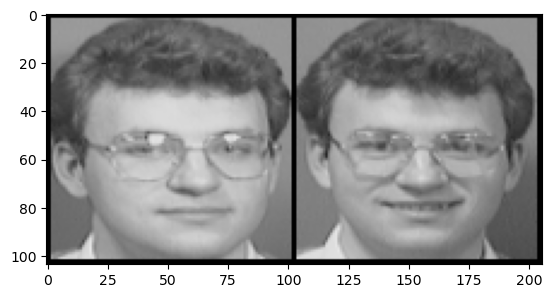

In [129]:
x0, _, _ = next(iter(test_loader))

for i in range(5):
    _, x1, label = next(iter(test_loader))
    
    conc = torch.cat((x0, x1), 0)
    
    out1, out2 = net(x0, x1)
    l2 = F.pairwise_distance(out1, out2)
    print(f'Dissimilarity: {l2.item():.2f}')
    img_show(torchvision.utils.make_grid(conc))